# Notebook 2: Multi-modal Gaussians

Here we fit a Mixture of Multi-Output Functions (MoM) to a Gaussian mixture by estimating its mean and co-variances.


In [1]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from models.mlp import MLP
from models.mixtureFFN import MixtureFFN
from models.mixtureOM import MixtureOfMultiFunction

sns.set_style('ticks')
sns.set_theme(style="white")
sns.set_palette("Set1")


# %matplotlib notebook
DEVICE = 'cpu'

#### Helper Functions

In [2]:
def train_loop(X_data, Y_data, model, optimizer, epochs=10, display=100, batch_size=32, hypo_count=None, device='cuda:0'):
    model.train()
    optimizer.zero_grad()
    total_steps = int(np.ceil(len(X_data) / batch_size))
    count = 0
    
    indexes = torch.randperm(Y_data.shape[0])
    X_shuffled = X_data[indexes]
    Y_shuffled = Y_data[indexes]

    model = model.to(device)

    for epoch in range(epochs):
        for step in range(total_steps):
            count += 1
            x = X_shuffled[step * batch_size:step * batch_size + batch_size]
            y = Y_shuffled[step * batch_size:step * batch_size + batch_size]
            
            log_loss = train_step(x, y, model, optimizer, hypo_count=hypo_count, device=device)
            if count % display == 0:
                print(f"E{epoch + 1}: loss={log_loss}")

            if hasattr(model, "restart_unused_mixtures"):
                model.restart_unused_mixtures()
            
            if hasattr(model, "set_epoch"):
                model.set_epoch(epoch)
                
def train_step(x, y, model, optimizer, hypo_count=None, device='cuda:0'):

    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    log_loss = None

    if model.__class__.__name__ == 'MixtureOfMultiFunction':
        output, _ = model.loss(x, y=y)
        loss = output['loss']
    elif model.__class__.__name__ == 'MixtureFFN': 
        loss = model.loss(x, y=y)[0]['loss'].mean()
    elif model.__class__.__name__ == 'MLP':
        loss = model(x,y)[-1].mean()
    else:
        raise ValueError(model.__class__.__name__)
    
    if log_loss is None:
        log_loss = loss.mean().detach().item()
    loss.backward()
    optimizer.step()
    return log_loss



### 1. Create dataset

In [3]:
# Dataset parameters
inp_dim = 2
out_dim = 2
dataset_sz = 1
outputs_per_input = 500

X_data = torch.normal(mean=0.0, std=torch.ones(dataset_sz, 1, inp_dim)).repeat(1, outputs_per_input, 1)

outputs_per_cluster = int(round(outputs_per_input / 3))

outputs_sz1 = 200
mean_1      = torch.tensor((0.75, 0.75))
std_1       = .1
Y_data_1    = torch.normal(mean=mean_1, std=torch.ones(dataset_sz, outputs_sz1, inp_dim) * std_1)

outputs_sz2 = 100
mean_2      = torch.tensor((-0.75, 0.75))
std_2       = .3
Y_data_2    = torch.normal(mean=mean_2, std=torch.ones(dataset_sz, outputs_sz2, inp_dim) * std_2)

outputs_sz3  = 200
mean_3       = torch.tensor((-0.0, -0.75))
cov_3        = torch.tensor([[.1, 0.0], [0.0, .025]])
distribution = torch.distributions.MultivariateNormal(mean_3, cov_3)
Y_data_3     = distribution.sample((dataset_sz, outputs_sz3, ))

print(Y_data_1.shape, Y_data_2.shape, Y_data_3.shape)

Y_data = torch.cat([Y_data_1, Y_data_2, Y_data_3], dim=1)
X_flat = torch.flatten(X_data, start_dim=0, end_dim=1)
Y_flat = torch.flatten(Y_data, start_dim=0, end_dim=1)

print(X_data.shape, X_flat.shape)
print(Y_data.shape, Y_flat.shape)

torch.Size([1, 200, 2]) torch.Size([1, 100, 2]) torch.Size([1, 200, 2])
torch.Size([1, 500, 2]) torch.Size([500, 2])
torch.Size([1, 500, 2]) torch.Size([500, 2])


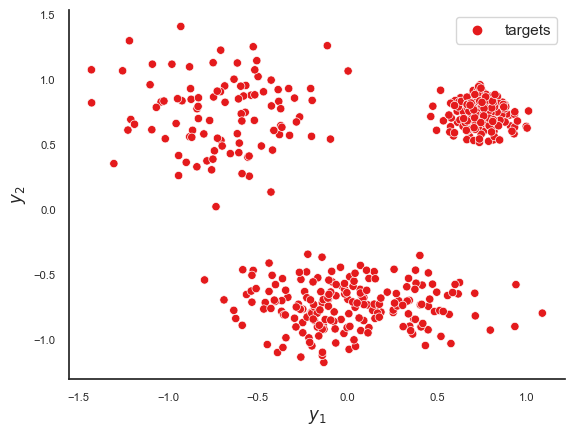

In [4]:
### Visualize labels (Y) with same input

df = pd.DataFrame(Y_flat.cpu().numpy(), columns=['y_1','y_2'])
df['type'] = 'targets'
df['size'] = 1.0
df['coefficient'] = None

axs = sns.scatterplot(data=df, x='y_1', y='y_2', hue='type')

plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs.set_xlabel("$y_1$")
axs.set_ylabel("$y_2$")

axs.legend(loc='upper right', title=None, frameon=True) #bbox_to_anchor=(1.1, 1.05),


Notice that there are multiple values of x for every y.

### 2. Initialize Hierarchical MH Dropout

In [5]:
# Model parameters
dropout_rate     = 0.5
inp_dim          = 2
out_dim          = 2
hid_dim          = 5
mhd_hid_dim      = 5

mix_components   = 3
num_layers       = 6
var_weight       = 1.0
subset_ratio     = 0.2

gate_sampling    = 'exact'
distance_loss    = 'mse'
act_fn           = 'tanh'
out_act_fn       = None

random_restart   = True       # (True, False)            Restarts unused mixtures  
sampling_policy  = 'multi'    # (greedy, multi, random)  Sampling policy for mixtures during inference

models = {}

In [6]:
models['FFN_MC_Dropout'] = MLP(
    inp_dim=inp_dim, hid_dim=hid_dim, out_dim=out_dim,
    num_layers=num_layers, act_fn=act_fn, distance_loss=distance_loss,
    out_act_fn=out_act_fn, dropout=dropout_rate
)

models['MixtureFFN_MC_Dropout'] = MixtureFFN(
    mix_components=mix_components, 
    inp_dim=inp_dim, 
    hid_dim=hid_dim, 
    out_dim=out_dim, 
    num_layers=num_layers,
    dropout=dropout_rate,
    act_fn=act_fn,
    out_act_fn=out_act_fn,
    random_restart=random_restart,
    sampling_policy=sampling_policy
)


In [7]:
models['MoM_MH_Dropout'] = MixtureOfMultiFunction(
            mix_components=mix_components,
            inp_dim=inp_dim, 
            hid_dim=hid_dim, 
            out_dim=out_dim, 
            mhd_hid_dim=mhd_hid_dim,
            num_layers=num_layers,
            act_fn=act_fn,
            out_act_fn=out_act_fn,
            gate_sampling=gate_sampling,
            subset_ratio=subset_ratio,
            distance_loss=distance_loss,
            var_weight=var_weight
            )

In [8]:
model_names = ['FFN_MC_Dropout','MixtureFFN_MC_Dropout','MoM_MH_Dropout']

In [9]:
# Check parameter counts. 
for model_name, model in models.items():
    param_count = sum(p.numel() for p in model.parameters())
    print("{:30} param={}".format(model_name, param_count))


FFN_MC_Dropout                 param=147
MixtureFFN_MC_Dropout          param=594
MoM_MH_Dropout                 param=864


In [10]:
opts = {}
for model_name, model in models.items():
    opts[model_name] = torch.optim.AdamW(list(models[model_name].parameters()))


### 3. Visualize hypotheses and labels (Y) before training.

In [11]:
def sample_model(model, X_data, max_hypos, df, sizes, data_index):
    model.eval()
    model.cpu()
    X_data.cpu()
    
    #Prepare outputs for graph
    x = X_data[data_index]
    
    if model.__class__.__name__ == 'MixtureOfMultiFunction':
        with torch.no_grad():
            outputs = model.sample(x=x)

        samples = outputs['samples']
        temp_df = pd.DataFrame(samples.cpu().numpy(), columns=['y_1', 'y_2'])
        temp_df['type'] = 'samples' 
        temp_df['size'] = sizes[1]
        df = pd.concat([df, temp_df], axis=0)

        mu = outputs['mu']
        temp_df = pd.DataFrame(mu.cpu().numpy(), columns=['y_1', 'y_2'])
        temp_df['type'] = 'mu' 
        temp_df['size'] = sizes[0]
        df = pd.concat([df, temp_df], axis=0)

    elif model.__class__.__name__ == 'MixtureFFN':

        # Predictive Mean: Turn dropout off.
        model.eval()
        with torch.no_grad():
            output = model.sample(x=x)
            mu = output['pred_sample'] 
            pidx = output['pidx_sample']

        #Predictive variance: Turn dropout on.
        model.train()
        with torch.no_grad():
            hypos = torch.stack([torch.stack([f(x) for f in model.ensemble], dim=-2) for _ in range(50)], dim=-2)
            all_sigma = hypos[torch.arange(mu.size(0)), pidx]
            sigma = torch.std(all_sigma, dim=1)
            samples = torch.randn_like(x) * sigma + mu

        temp_df = pd.DataFrame(samples.cpu().numpy(), columns=['y_1', 'y_2'])
        temp_df['type'] = 'samples'
        temp_df['size'] = sizes[-1]
        df = pd.concat([df, temp_df], axis=0)

        temp_df = pd.DataFrame(mu.cpu().numpy(), columns=['y_1', 'y_2'])
        temp_df['type'] = 'mu'
        temp_df['size'] = sizes[0]
        df = pd.concat([df, temp_df], axis=0)

    elif model.__class__.__name__ in ['MLP']:
        
        # Predictive Mean: Turn dropout off.
        model.eval()
        with torch.no_grad():
            mu = model.sample(x=x, hypo_count=max_hypos)['pred_sample'] 

        #Predictive variance: Turn dropout on.
        model.train()
        with torch.no_grad():
            preds = [model.sample(x=x, hypo_count=max_hypos)['pred_sample'] for _ in range(50)]
            preds = torch.stack(preds, dim=1)
            sigma = torch.std(preds, dim=1)
            samples = torch.randn_like(x) * sigma + mu

        temp_df = pd.DataFrame(samples.cpu().numpy(), columns=['y_1', 'y_2'])
        temp_df['type'] = 'samples'
        temp_df['size'] = sizes[-1]
        df = pd.concat([df, temp_df], axis=0)

        temp_df = pd.DataFrame(mu.cpu().numpy(), columns=['y_1', 'y_2'])
        temp_df['type'] = 'mu'
        temp_df['size'] = sizes[0]
        df = pd.concat([df, temp_df], axis=0)

    else:   
        print(model.__class__.__name__)
        raise

    return df

### 4. Train model

Train the model until loss is stable.


In [12]:
epochs = 1000
display = 5000
batch_size = 500
max_hypos = None
sizes = [1.0,1.5]

In [13]:
for model_name, model in models.items():
    print(model_name)
    train_loop(X_flat, Y_flat, model, opts[model_name], 
               epochs=epochs, display=display, batch_size=batch_size, device=DEVICE)

FFN_MC_Dropout
MixtureFFN_MC_Dropout
MoM_MH_Dropout


### 5. Visualize hypotheses and labels (Y) *after* training.

In [14]:
steady_dfs = {}

for model_name, model in models.items():
        steady_dfs[model_name] = sample_model(
                model, X_data, max_hypos, df, sizes, 0)

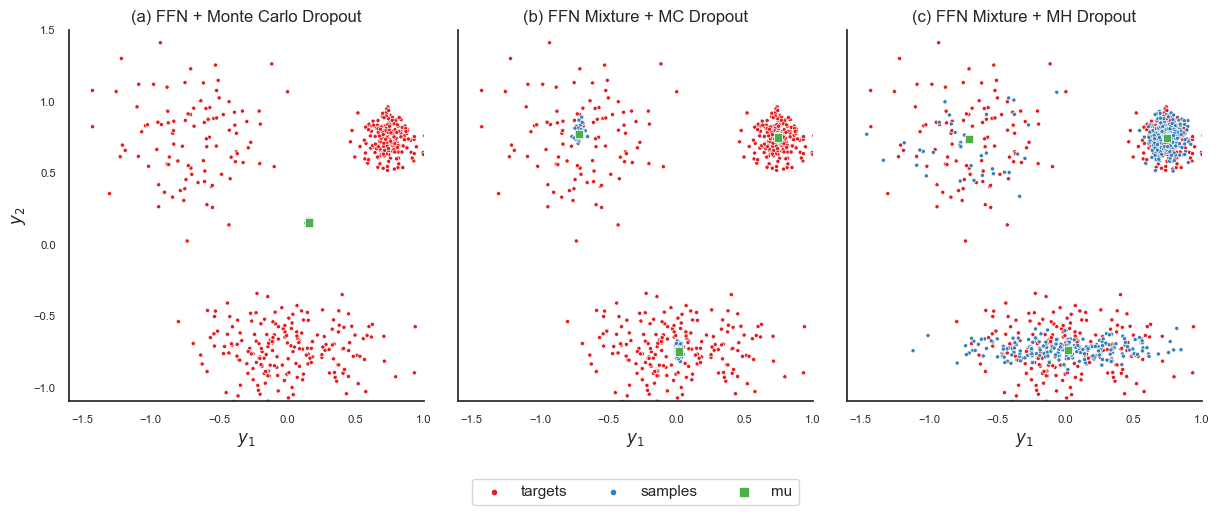

In [15]:
xlim = (-1.6, 1.)
ylim = (-1.1, 1.5)

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True) #, gridspec_kw={'height_fractions': [2,1]})

# Steady State:
for idx, model_name in enumerate(model_names):
    legend = 'auto' if idx == 1 else False
    sns.scatterplot(data=steady_dfs[model_name], x='y_1', y='y_2', 
                    hue='type', style='type', ax=axes[idx], 
                    legend=legend,markers={'targets': '.', 'mu': 's','samples': '.'})
    
    axes[idx].set_title(model_name)
    axes[idx].set_xlim(*xlim)
    axes[idx].set_ylim(*ylim)
    axes[idx].set_xlabel("$y_1$")

    #Reduce tick size
    axes[idx].tick_params(axis='x', labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

axes[0].set_ylabel("$y_2$")
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), fancybox=True, title=None, frameon=True, ncol=3) #bbox_to_anchor=(1.1, 1.05),

axes[0].set_title('(a) FFN + Monte Carlo Dropout')
axes[1].set_title('(b) FFN Mixture + MC Dropout')
axes[2].set_title('(c) FFN Mixture + MH Dropout')

pad_size = 0.01
plt.tight_layout(pad=pad_size, w_pad=pad_size, h_pad=pad_size)
